# $sin(x + y)$
This notebook shows how you can use a Gaussian Process to estimate a 2-dimensional function $f(x, y) = sin(x + y)$.

In [1]:
%matplotlib notebook

In [2]:
from __future__ import print_function

import theano
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from gp import GaussianProcess

In [3]:
def secret_function(x, noise=0.0):
    # sin(x + y)
    x_sum = x[0] + x[1]
    return np.matrix(np.sin(x_sum) + noise * np.random.normal(size=x_sum.shape))

In [4]:
def as_shared(x, name, borrow=True):
    return theano.shared(value=x, name=name, borrow=borrow)

We sample 50 pairs of points $(x, y)$ four times and push them through our *secret* function. We reuse the same points simply to show that the function is noisy and that the Gaussian Process is robust against it.

In [5]:
# Training data.
X = np.random.uniform(-4, 4, 100).reshape(-2, 2)
X = np.vstack([X, X, X, X])
X = as_shared(X, "X")
Y = as_shared(secret_function(X.get_value().T, noise=1e-1).T, "Y")

In [6]:
# Test data.
DATA_SIZE = 100
x = np.linspace(-4, 4, DATA_SIZE)
y = np.linspace(-4, 4, DATA_SIZE)
x, y = np.meshgrid(x, y)  # We need a grid for 3D plot.

# Real function.
x_test = np.stack([x, y]).reshape(2, -1).T
z = secret_function(np.stack([x, y])).reshape(DATA_SIZE, DATA_SIZE)

<IPython.core.display.Javascript object>


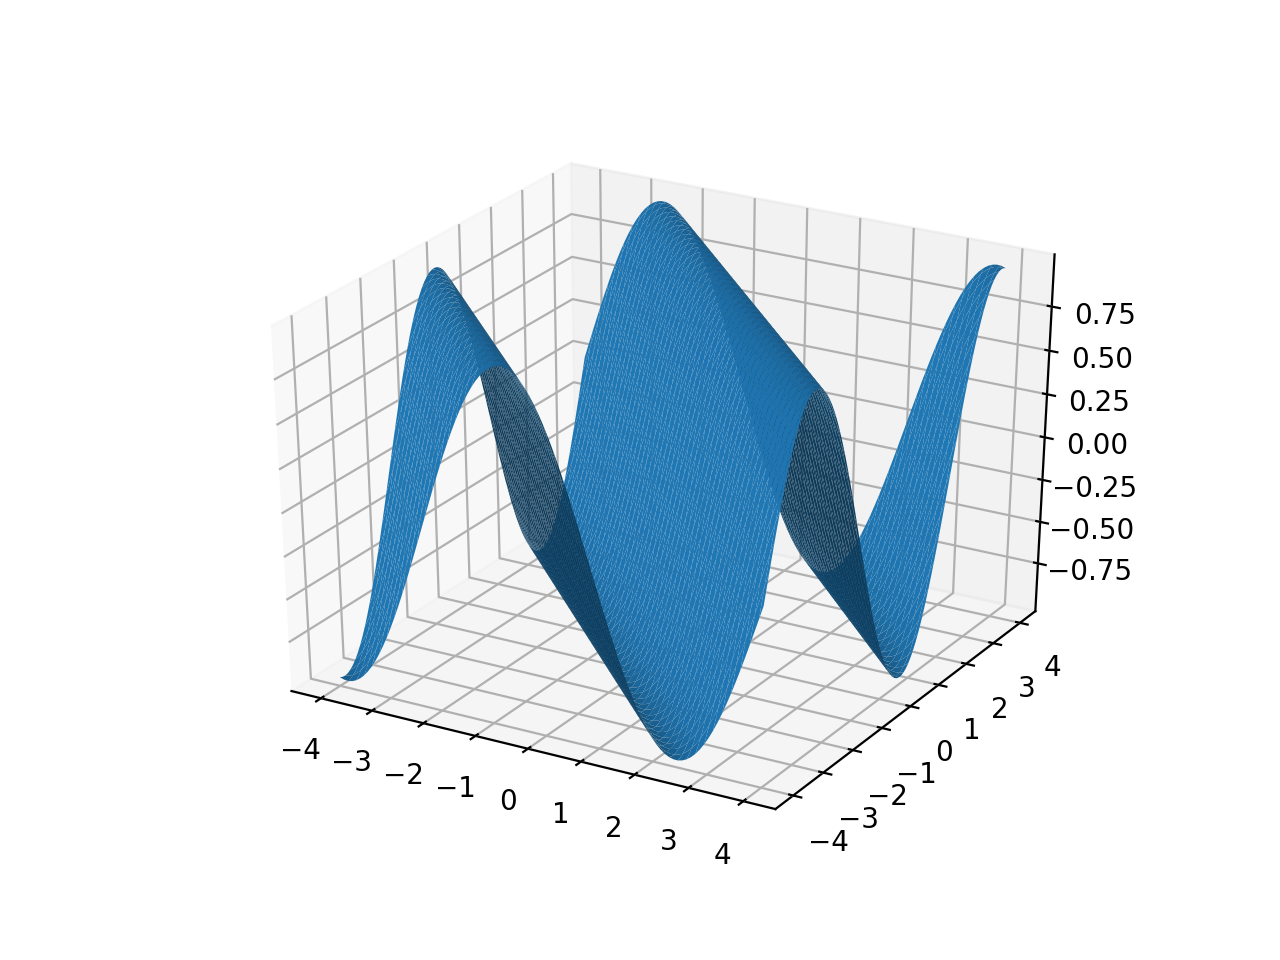

In [7]:
# Plot the real function.
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(x, y, z)

In [8]:
# Fit the Gaussian Process.
# Set xdim in order to use a vector length scale.
gp = GaussianProcess(xdim=2)
gp.fit(X, Y)
gp.compile()

In [9]:
for param in gp.hyperparameters:
    print(param.name, param.get_value())

length_scale [ 1.36936469  1.42008701]
sigma_s 1.0
sigma_n 0.018995544829420466


In [10]:
z_test = gp.compute_mean(x_test).reshape(DATA_SIZE, DATA_SIZE)

In [11]:
std_dev = gp.compute_standard_deviation(x_test).reshape(DATA_SIZE, DATA_SIZE)

<IPython.core.display.Javascript object>


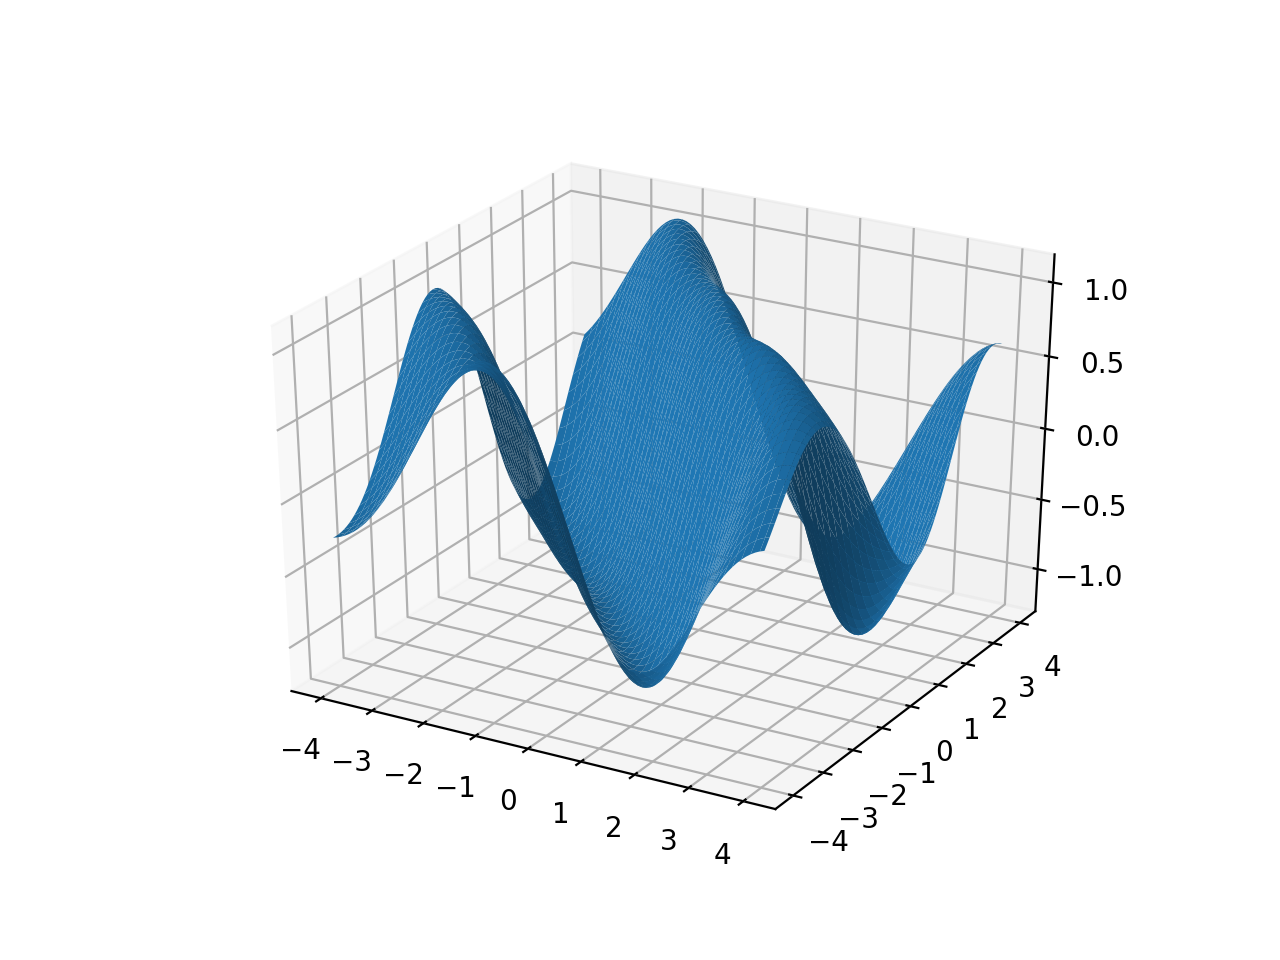

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(x, y, z_test)

<IPython.core.display.Javascript object>


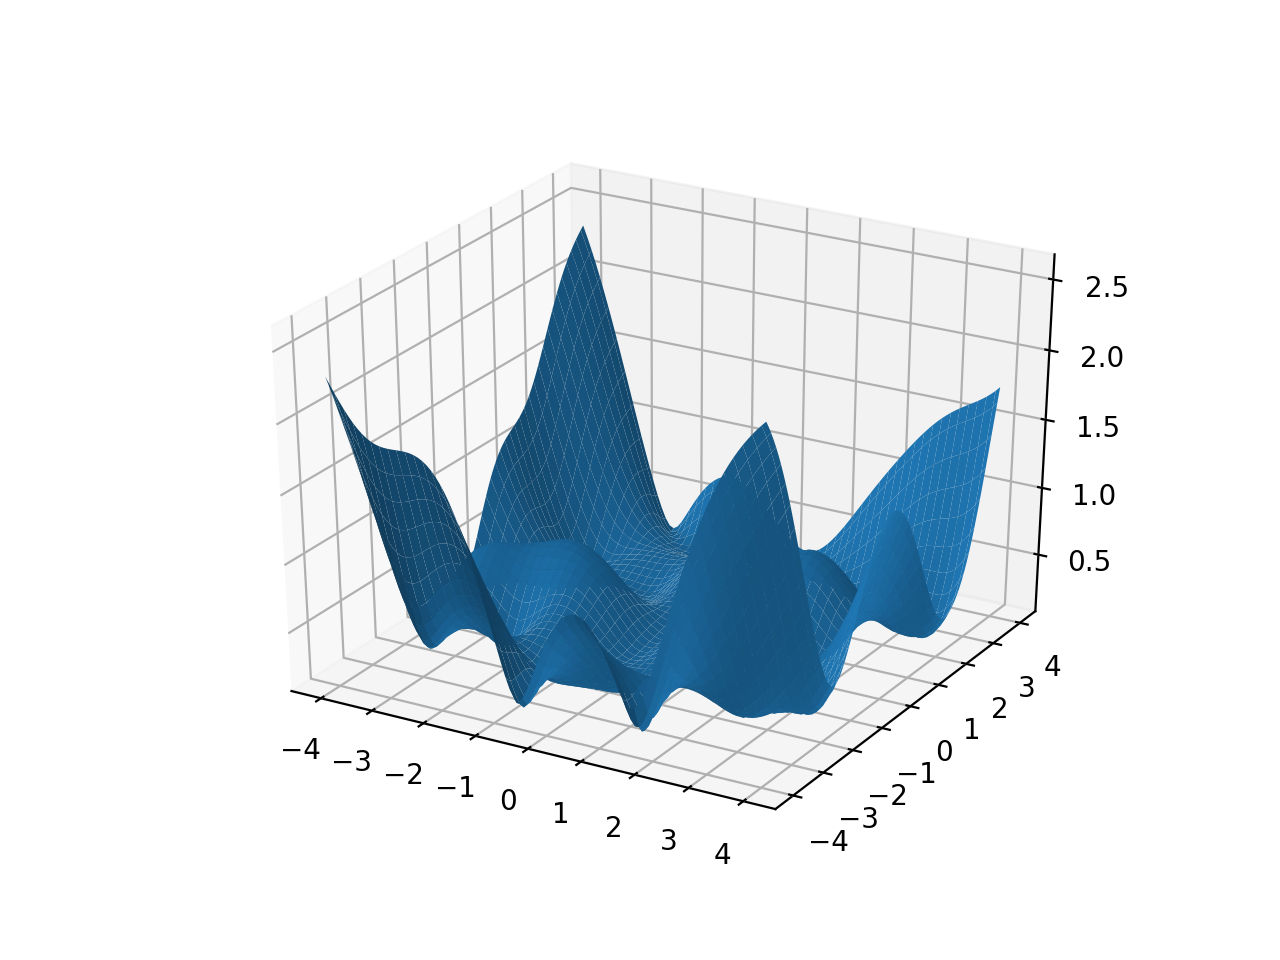

In [13]:
# Plot uncertainty as 3 standard deviations.
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(x, y, 3 * std_dev)